In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [118]:
df= pd.read_csv("/content/DELL.csv")
df1=df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,21.777945,22.993132,21.693752,22.440264,21.538488,13801490
1,2017-12-04,22.504812,22.521650,20.952852,21.017401,20.172800,8513645
2,2017-12-05,20.927595,21.278399,20.644144,20.899530,20.059671,6129126
3,2017-12-06,20.767628,21.182980,20.697468,21.065109,20.218594,7828790
4,2017-12-07,21.278399,21.601139,21.205433,21.298044,20.442167,7163534
...,...,...,...,...,...,...,...
1386,2023-06-07,46.860001,47.779999,46.770000,47.660000,47.660000,4096000
1387,2023-06-08,47.990002,48.099998,47.200001,47.889999,47.889999,3976100
1388,2023-06-09,48.090000,48.669998,47.590000,47.610001,47.610001,3293500
1389,2023-06-12,47.720001,48.119999,47.619999,48.070000,48.070000,3596800


In [119]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [120]:
# 4. Chia train test
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [121]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [122]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [125]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [126]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [127]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
10/10 [==============================] - 4s 187ms/step - loss: 0.0320 - val_loss: 0.1167
Epoch 2/100
10/10 [==============================] - 1s 92ms/step - loss: 0.0055 - val_loss: 0.0412
Epoch 3/100
10/10 [==============================] - 1s 68ms/step - loss: 0.0030 - val_loss: 0.1059
Epoch 4/100
10/10 [==============================] - 1s 69ms/step - loss: 0.0025 - val_loss: 0.0887
Epoch 5/100
10/10 [==============================] - 1s 70ms/step - loss: 0.0017 - val_loss: 0.0571
Epoch 6/100
10/10 [==============================] - 1s 68ms/step - loss: 0.0016 - val_loss: 0.0571
Epoch 7/100
10/10 [==============================] - 1s 70ms/step - loss: 0.0014 - val_loss: 0.0520
Epoch 8/100
10/10 [==============================] - 1s 69ms/step - loss: 0.0012 - val_loss: 0.0396
Epoch 9/100
10/10 [==============================] - 1s 69ms/step - loss: 0.0011 - val_loss: 0.0321
Epoch 10/100
10/10 [==============================] - 1s 70ms/step - loss: 9.2975e-04 - val_loss: 0

In [128]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 19ms/step


In [129]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [130]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 40.068303971071366
Testing RMSE: 49.58350598935465


In [131]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=218
n_stepss=75
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_stepss, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.64215625 0.64627444 0.64085585 0.66708181 0.66794881 0.66014601
 0.70652915 0.71454862 0.72798679 0.72972069 0.73600628 0.71953381
 0.74359228 0.71606582 0.69807615 0.70024356 0.69330777 0.72105101
 0.58081785 0.56261139 0.54310444 0.51276038 0.49888881 0.5019232
 0.49108602 0.50604131 0.51731197 0.54527192 0.5563258  0.51297708
 0.50929248 0.49888881 0.5056078  0.50257341 0.48371674 0.48003205
 0.46919487 0.45272238 0.43494942 0.43538291 0.4477373  0.42389545
 0.42346195 0.46052517 0.49477062 0.5034404  0.49520412 0.43278192
 0.43018104 0.41695966 0.41479224 0.44123501 0.42541264 0.42996432
 0.43191501 0.43039783 0.43841732 0.48154923 0.49086923 0.5008395
 0.5019232  0.5012729  0.53161705 0.51514458 0.53140035 0.49932221
 0.49238641 0.52814915 0.54700583 0.5589267  0.53530174 0.58710344
 0.6079108  0.59859083 0.60075822 0.57539926 0.58797035 0.59403923
 0.57301508 0.63326976 0.64974234 0.65017583 0.62741777 0.62611727
 0.65364373 0.65602793 0.64822514 0.6163638  0.60335

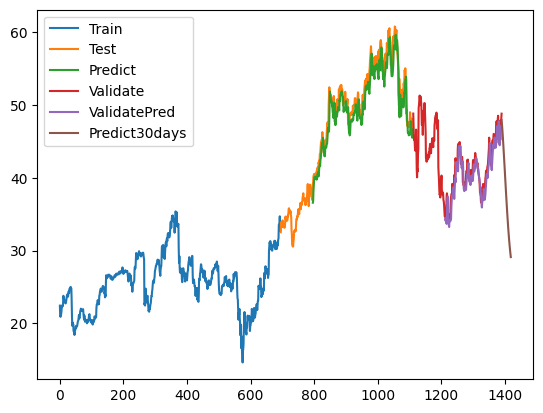

In [132]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()